# Pronóstico del precio de clausura de Bitcoin mediante redes neuronales

El objetivo de este producto integrador de aprendizaje es utilizar métodos de sistemas adaptativos (en este caso, una red neuronal multicapa) para pronóstico de series de tiempo. Este problema es muy común, considerando que existe una gran cantidad de escenarios donde los datos forman una secuencia temporal--es decir, se generan valores a lo largo del tiempo. Algunos de estos escenarios incluyen los perfiles de consumo de energía (cantidad consumida a lo largo de un mes, por ejemplo), las calificaciones de un alumno durante un semestre, los índices de contaminación a lo largo de un día y la bolsa de valores--entre otros.

El escenario que analizamos para este PIA consiste en el precio del *Bitcoin*, que es una de las cripto-monedas más conocidas y utilizadas de los últimos años. En este caso, nos enfocaremos en pronosticar el precio de cierre de esta moneda utilizando redes neuronales.

## Librerías

In [ ]:
#LIBRERÍAS

#Redes neuronales: Tensorflow, Keras, sklearn
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR) #Silencio! (No desplegar advertencias) Poner antes de tf import
import tensorflow as tf
tf.autograph.set_verbosity(0) #Silencio! (No desplegar advertencias)
from tensorflow import keras

from keras import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#Ciencia de datos: Numpy, Pandas, Seaborn
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Auxiliares
import sys

## Funciones auxiliares

Las dos funciones que estaremos usando como apoyo son *calcular_mse(...)* y *generar_ventanas(...)*. Mientras que la primera nos permite calcular el error cuadrático medio (MSE, por sus siglas en inglés) entre un conjunto de valores (y) y un conjunto de valores estimados (y_hat), la segunda nos permite generar un conjunto de datos a partir de una serie univariada.

In [ ]:
def calcular_rmse(y, y_hat):
    return np.sqrt(mean_squared_error(y, y_hat))

In [ ]:
def generar_ventanas(datos_preproc, ventana):
    X, y = [], []
    for i in range(len(datos_preproc) - ventana):
        X.append(datos_preproc[i:i+ventana,0])
        y.append(datos_preproc[i+ventana,0])
    X, y = np.array(X), np.array(y)
    return X,y

## Lectura del conjunto de datos

Carga los datos en un dataframe de pandas y muestra las primeras líneas de este dataframe. *Tip:* Utiliza los métodos *read_csv(...)* y *head()* de esta librería. Recuerda que este ejercicio ya se hizo para las entregas anteriores.

In [ ]:
#Leer el archivo y cargarlo en un dataframe
rutaCSV="/content/bitcoin_diario_clausura.csv"
df=pd.read_csv(rutaCSV)
df.head()

,fecha,clausura
0,01/03/2022 00:00,43185.48
1,28/02/2022 00:00,43178.98
2,27/02/2022 00:00,37712.68
3,26/02/2022 00:00,39146.66
4,25/02/2022 00:00,39231.64


In [ ]:
df_claus=df['clausura']
df_claus.head()

0    43185.48
1    43178.98
2    37712.68
3    39146.66
4    39231.64
Name: clausura, dtype: float64

## Pre-procesamiento

Convierte el dataframe con los precios de cierre (*df_claus*) en un array de numpy, y re-dimensiónalo con *.reshape(-1,1)*. Esto nos servirá para poder realizar operaciones sobre los datos de una manera más sencilla.

In [ ]:
#Conversión a array de numpy
datos=np.array(df_claus)
datos=datos.reshape(-1,1)

#Ver las dimensiones del conjunto de datos
print("Dimensiones del conjunto de datos: ",datos.shape)


Dimensiones del conjunto de datos:  (2651, 1)


Estandariza el array previamente obtenido utilizando el *MinMaxScaler()*. Esta estandarización nos ayudará a tener acotados los valores del conjunto.

Muestra los 10 primeros renglones del conjunto de datos estandarizado.

In [ ]:
scaler = MinMaxScaler()

#Estandarización min-max
datos_estandarizados=scaler.fit_transform(datos)

datos_estandarizados[:10]

array([[0.63835898],
       [0.63826253],
       [0.55715655],
       [0.57843316],
       [0.57969405],
       [0.56701159],
       [0.55065033],
       [0.56542487],
       [0.54771874],
       [0.56696737]])

## Generación de conjuntos de prueba y entrenamiento

Ahora genera, a partir de los datos estandarizados, los conjuntos **X** y **y**, donde el primero contiene los vectores de características y el segundo contiene las etiquetas. Posteriormente, divide cada uno de estos conjuntos en entrenamiento y prueba, de tal manera que termines con los conjuntos **X_train**, **y_train**, **X_test** y **y_test**.

Primero, vamos a definir los tamaños de cada conjunto. Considera 70% de los datos para entrenar y 30% para probar.

In [ ]:
ventana=8 #Tomaremos los 7 valores previos

#tamaño del conjunto de datos.
n=len(datos_estandarizados)

m=n-ventana

#tamaño del conjunto de entrenamiento
tam_entrenamiento=int(0.7*n)

tam_prueba=n-tam_entrenamiento-ventana

print("Vectores para entrenamiento:",tam_entrenamiento)
print("Vectores para prueba: ",tam_prueba)

Vectores para entrenamiento: 1855
Vectores para prueba:  788


Ahora, genera los conjuntos **X** y **y**, utilizando para ello la función *generar_ventanas(...)*

In [ ]:
#Genera vectores de características. Cada vector consiste en el precio i y los x precios anteriores (i-7...i-1),
#donde x es el tamaño de la ventana. En este caso, la etiqueta numérica sería el precio i

#def generar_ventanas(datos_preproc, ventana):
    #X, y = [], []
    #for i in range(len(datos_preproc) - ventana):
        #X.append(datos_preproc[i:i+ventana,0])
        #y.append(datos_preproc[i+ventana,0])
    #X, y = np.array(X), np.array(y)
    #return X,y

#Genera los vectores X,y (tip: recuerda las funciones auxiliares)
X,y=generar_ventanas(datos_estandarizados, ventana)


In [ ]:
X[:5]

array([[0.63835898, 0.63826253, 0.55715655, 0.57843316, 0.57969405,
        0.56701159, 0.55065033, 0.56542487],
       [0.63826253, 0.55715655, 0.57843316, 0.57969405, 0.56701159,
        0.55065033, 0.56542487, 0.54771874],
       [0.55715655, 0.57843316, 0.57969405, 0.56701159, 0.55065033,
        0.56542487, 0.54771874, 0.56696737],
       [0.57843316, 0.57969405, 0.56701159, 0.55065033, 0.56542487,
        0.54771874, 0.56696737, 0.59271214],
       [0.57969405, 0.56701159, 0.55065033, 0.56542487, 0.54771874,
        0.56696737, 0.59271214, 0.5910499 ]])

In [ ]:
y[:5]

array([0.54771874, 0.56696737, 0.59271214, 0.5910499 , 0.59934582])

Genera **X_train**, **X_test**, **y_train**, y **y_test** a partir de **X**, **y** y *tam_entrenamiento*.

In [ ]:
#Genera los conjuntos de entrenamiento y prueba (vectores y etiquetas)
X_train=X[:tam_entrenamiento]
X_test=X[tam_entrenamiento:tam_entrenamiento+tam_prueba]
y_train=y[:tam_entrenamiento]
y_test=y[tam_entrenamiento:tam_entrenamiento+tam_prueba]

y_train=y_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)

In [ ]:
print("Dimensiones de X: ",X.shape)
print("Dimensiones de y: ",y.shape)
print("Dimensiones de X_train: ",X_train.shape)
print("Dimensiones de X_test: ",X_test.shape)
print("Dimensiones de y_train: ",y_train.shape)
print("Dimensiones de y_test: ",y_test.shape)

Dimensiones de X:  (2643, 8)
Dimensiones de y:  (2643,)
Dimensiones de X_train:  (1855, 8)
Dimensiones de X_test:  (788, 8)
Dimensiones de y_train:  (1855, 1)
Dimensiones de y_test:  (788, 1)


## Generación de modelos de aprendizaje

Genera tres modelos de aprendizaje. El primero tendrá una capa oculta de cinco unidades. El segundo tendrá dos capas ocultas de cinco unidades cada una. El tercer modelo será diseñado por tu equipo: escoge la cantidad de capas ocultas y la cantidad de unidades para cada capa. En todos los modelos, la capa de salida tendrá una sola unidad.

In [ ]:
modelos=[]

#Diseño del Modelo A
modelo_a = Sequential()
modelo_a.add(Dense(5, activation='relu'))
modelo_a.add(Dense(1))
modelos.append(modelo_a)

modelo_b = Sequential()
#Diseño del modelo B (2 capas ocultas de 5 unidades c/u)
modelo_b.add(Dense(5, activation='relu'))
modelo_b.add(Dense(5, activation='relu'))
modelo_b.add(Dense(1))
modelos.append(modelo_b)

modelo_c = Sequential()
#Diseño del modelo C 

modelo_c.add(Dense(5, activation='relu'))
modelo_c.add(Dense(6, activation='relu'))
modelo_c.add(Dense(1))
modelos.append(modelo_c)

nombres_modelos=["Modelo A","Modelo B","Modelo C"]

In [ ]:
#Listas para guardar las predicciones de entrenamiento, las predicciones de prueba y los errores
Y_train_pred_inverse=[]
Y_test_pred_inverse=[]
errores=[]

In [ ]:
@tf.autograph.experimental.do_not_convert
def run(modelos,nombres_modelos,X_train,X_test,y_train,y_test,scaler):

    for i in range(len(modelos)):
        errs_modelo=[]
        mejor_mse=sys.float_info.max

        print("--------------Probando ",nombres_modelos[i],"---------------")

        modelo=modelos[i]
        modelo.compile(loss='mean_squared_error', optimizer='adam')


        for j in range(3):
            #Entrenar el modelo y obtener las predicciones de entrenamiento, las pred. de prueba y el error
            modelo.fit(X_train, y_train)
            y_train_pred = modelo.predict(X_train)
            y_test_pred = modelo.predict(X_test)
            rmse_ejecucion = calcular_rmse(y_test,y_test_pred)

            print("   Raíz del error medio cuadrático (RMSE):",round(rmse_ejecucion,4))
            errs_modelo.append(rmse_ejecucion)

            if rmse_ejecucion<mejor_mse:
                mejor_mse=rmse_ejecucion
                mejor_modelo=modelo

        print("Mejor MSE: ",mejor_mse)

        #Calcular las predicciones de entrenamiento y prueba con la mejor ejecución del modelo
   
        y_train_pred = mejor_modelo.predict(X_train)
        y_test_pred = mejor_modelo.predict(X_test)

        #Calcular las predicciones sin estandarización.

        y_train_pred_inverse=scaler.inverse_transform(y_train_pred)
        y_test_pred_inverse=scaler.inverse_transform(y_test_pred)

        Y_train_pred_inverse.append(y_train_pred_inverse)
        Y_test_pred_inverse.append(y_test_pred_inverse)

        errores.append(errs_modelo)

    return [Y_train_pred_inverse,Y_test_pred_inverse,errores]

In [ ]:
#Correr el entrenamiento de los tres modelos
[Y_train_pred_inverse, Y_test_pred_inverse, errores] = run(modelos, nombres_modelos, X_train, X_test, y_train, y_test, scaler)

--------------Probando  Modelo A ---------------
25/25 [==============================] - 0s 1ms/step
   Raíz del error medio cuadrático (RMSE): 0.0841
25/25 [==============================] - 0s 3ms/step
   Raíz del error medio cuadrático (RMSE): 0.1436
25/25 [==============================] - 0s 1ms/step
   Raíz del error medio cuadrático (RMSE): 0.1486
Mejor MSE:  0.08411342872084673
25/25 [==============================] - 0s 2ms/step
--------------Probando  Modelo B ---------------
25/25 [==============================] - 0s 1ms/step
   Raíz del error medio cuadrático (RMSE): 0.0491
25/25 [==============================] - 0s 2ms/step
   Raíz del error medio cuadrático (RMSE): 0.0937
25/25 [==============================] - 0s 2ms/step
   Raíz del error medio cuadrático (RMSE): 0.1306
Mejor MSE:  0.049114024202266134
25/25 [==============================] - 0s 2ms/step
--------------Probando  Modelo C ---------------
25/25 [==============================] - 0s 1ms/step
   Raíz del

## Comparación de modelos

In [ ]:
datos_errores={}
for i in range(len(modelos)):
    datos_errores[nombres_modelos[i]]=errores[i]

#Generar un dataframe a partir del diccionario datos_errores
df_errores=pd.DataFrame(datos_errores)

df_errores

,Modelo A,Modelo B,Modelo C
0,0.084113,0.049114,0.058092
1,0.143558,0.093679,0.109308
2,0.148602,0.130607,0.128575


### Análisis de varianza (ANOVA)

In [ ]:
valor_f, valor_p = stats.f_oneway(df_errores['Modelo A'], df_errores['Modelo B'], df_errores['Modelo C'])
print("Valor p: ",valor_p)

Valor p:  0.5403300049963952


# Visualizaciones

## Datos originales

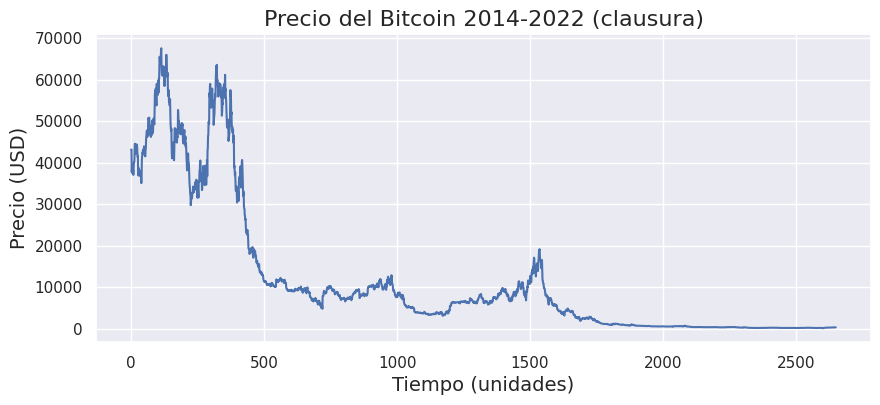

In [ ]:
sns.set()
plt.figure(figsize=(10, 4))
plt.title("Precio del Bitcoin 2014-2022 (clausura)", fontsize=16)
plt.xlabel("Tiempo (unidades)", fontsize=14)
plt.ylabel("Precio (USD)", fontsize=14)

#Generar una gráfica con los datos originales (dataframe con precios de clausura)
plt.plot(df["clausura"])

## Entrenamiento y prueba

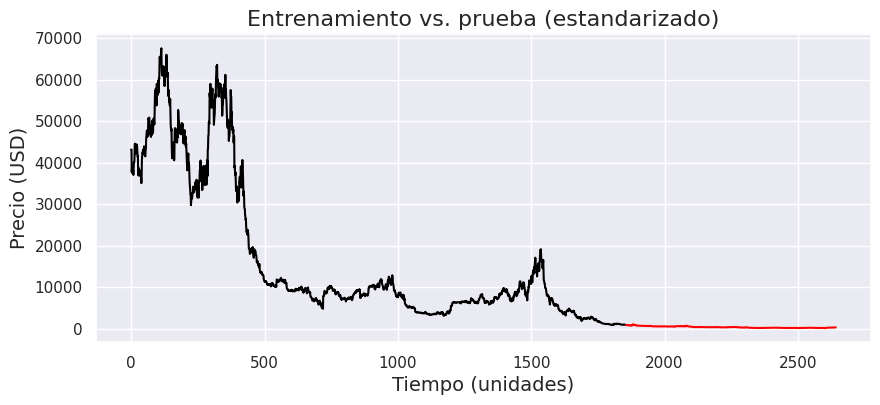

In [ ]:
plt.figure(figsize=(10, 4))
plt.title("Entrenamiento vs. prueba (estandarizado)",fontsize=16)
plt.xlabel("Tiempo (unidades)", fontsize=14)
plt.ylabel("Precio (USD)", fontsize=14)

#Graficar el conjunto de entrenamiento (línea negra)
plt.plot(df["clausura"][:tam_entrenamiento], color="black")

#Graficar el conjunto de prueba (línea roja)
plt.plot(df["clausura"][tam_entrenamiento:tam_entrenamiento+tam_prueba], color="red")

### Predicciones: Original vs. entrenamiento

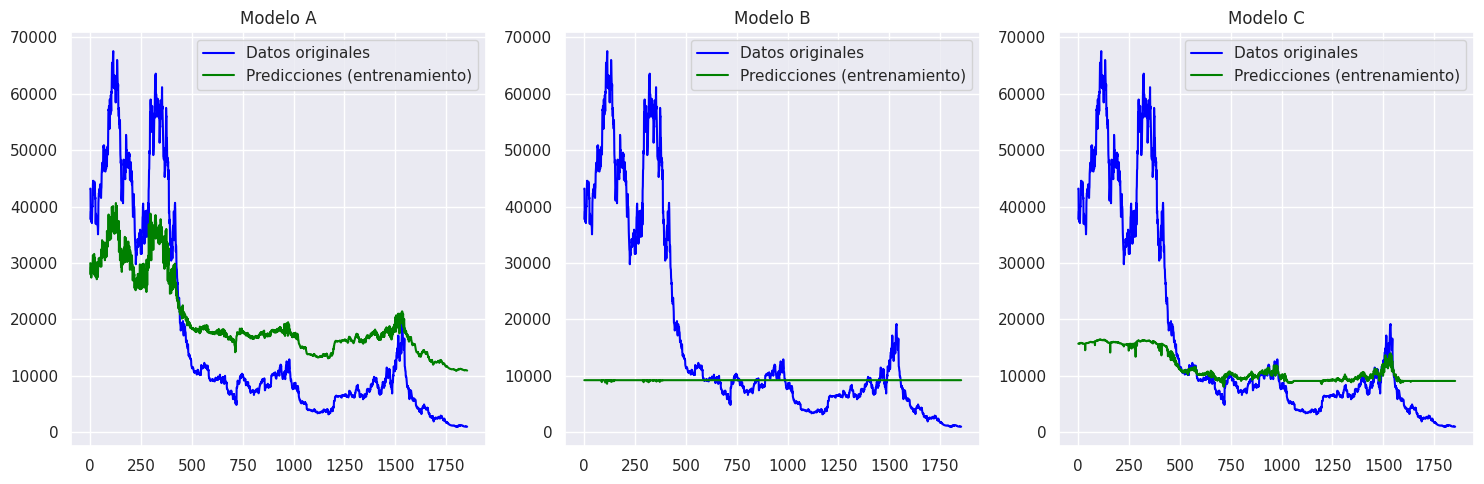

In [ ]:
#Graficar las predicciones de entrenamiento para los tres modelos (utilizando una gráfica múltiple)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i in range(len(modelos)):
    axs[i].plot(np.arange(tam_entrenamiento), datos[:tam_entrenamiento], label='Datos originales', color='blue')

    axs[i].plot(np.arange(tam_entrenamiento), Y_train_pred_inverse[i], label='Predicciones (entrenamiento)', color='green')

    axs[i].set_title(nombres_modelos[i])

    axs[i].legend(loc='upper right')
plt.tight_layout()
plt.show()

### Predicciones: Original vs. prueba

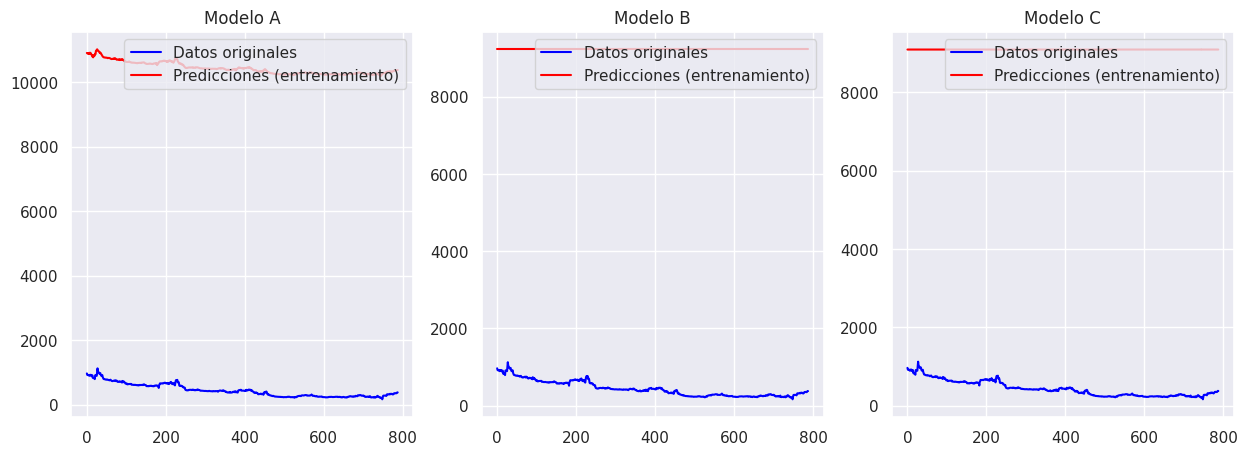

In [ ]:
#Graficar las predicciones de prueba para los tres modelos (utilizando una gráfica múltiple)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i in range(len(modelos)):
    
    axs[i].plot(np.arange(tam_prueba), datos[tam_entrenamiento:tam_entrenamiento+tam_prueba], label='Datos originales', color='blue')

    axs[i].plot(np.arange(tam_prueba), Y_test_pred_inverse[i], label='Predicciones (entrenamiento)', color='red')

    axs[i].set_title(nombres_modelos[i])

    axs[i].legend(loc='upper right')

plt.show()

### Comparación (gráficas caja-bigote)

([<matplotlib.axis.XTick at 0x7db8a5849b40>,
 [Text(0, 0, 'Modelo A'), Text(1, 0, 'Modelo B'), Text(2, 0, 'Modelo C')])

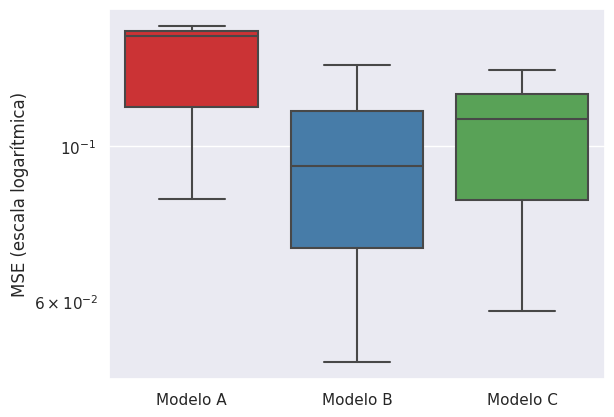

In [ ]:
cant_modelos=len(modelos)

plt.yscale('log')
plt.ylabel('MSE (escala logarítmica)')

#Graficar los errores mediante boxplots de seaborn
sns.boxplot(data=errores, palette="Set1")

plt.xticks(ticks=np.arange(0,cant_modelos),labels=nombres_modelos)